Here we use the components extracted in the previous step and the timestamped data from the behavior

In [2]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix
from scipy.stats import sem

from IPython import get_ipython
import IPython

from ipyfilechooser import FileChooser

from scipy.ndimage import binary_erosion

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [4]:
# Load the data
path = 'D:/CaIm/os80/b3/'

# Video
os80 = 'D:/CaIm/os80/memmap__d1_512_d2_512_d3_1_order_C_frames_12000.mmap'  # Replace with your .mmap file path
os80_lawa2 = path + 'memmap_d1_512_d2_512_d3_1_order_C_frames_6998.mmap'
mmap_file_path = os80_lawa2
Yr, dims, T = cm.load_memmap(mmap_file_path)
#Reshape the data back into a movie:
images = np.reshape(Yr.T, [T] + list(dims), order='F')

# Components data from JSON files
a_data = path + 'A_data.json'
c_data = path + 'C_data.json'
accepted = path + 'accepted.json'

with open(a_data, 'r') as json_file:
    A_list = json.load(json_file)
with open(c_data, 'r') as json_file:
    C_list = json.load(json_file)
with open(accepted, 'r') as json_file:
    accepted_list = json.load(json_file)

# Convert lists back to numpy array and then to sparse matrix if needed
A_array = np.array(A_list)
A_sparse = csc_matrix(A_array)
C_array = np.array(C_list)

# show a frame
#plt.imshow(images[0], cmap='gray')
#plt.show()

In [5]:
# Select only accepted:
A_array = A_array[:,accepted_list]
C_array = C_array[accepted_list,:]

select a poligon where neurons could be

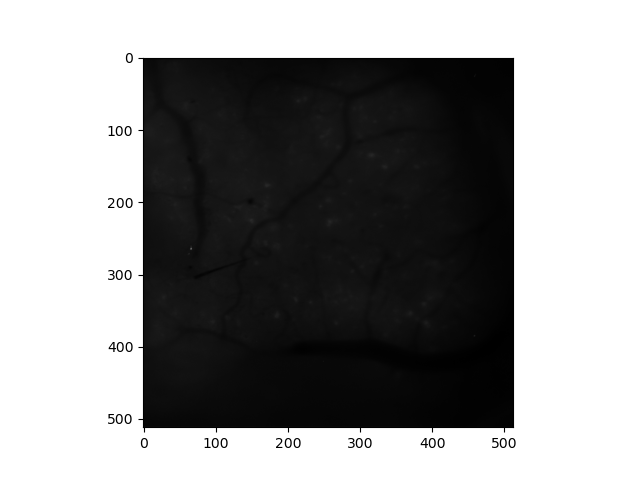

In [6]:
%matplotlib widget
#%matplotlib ipympl
# Make an image with max values of intensity
max_image = np.max(images, axis=0)


fig, ax = plt.subplots()
ax.imshow(max_image, cmap='gray')
polygon_points = []

def on_click(event):
    if event.inaxes is not None:
        polygon_points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the vertices
        
        if len(polygon_points) == 7:  # When 7 points are chosen
            poly = Polygon(polygon_points, closed=True, edgecolor='r', fill=False)
            ax.add_patch(poly)
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event

            plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()


In [7]:
# Original dimentions
d1 = 512
d2 = 512

def calculate_centroid(A_array, component_num, d1, d2):
    """Calculate the centroid of a component."""
    component = A_array[:, component_num].reshape(d1, d2)
    ys, xs = np.nonzero(component)
    if len(xs) == 0 or len(ys) == 0:
        return None  # or some default value like (0, 0)
    return np.mean(xs), np.mean(ys)

# Assuming A_array shape is (height, width, num_components)
#spatial_component = A_array[:, component_num].reshape(d1, d2)
centroids = [calculate_centroid(A_array, i, d1, d2) for i in np.arange(A_array.shape[1])]

# Filter out None values if there are any
centroids = [centroid for centroid in centroids if centroid is not None]


def is_inside_polygon(points, polygon):
    path = Path(polygon)
    return np.array([path.contains_point(point) for point in points])

is_inside = is_inside_polygon(centroids, polygon_points)

# Filter arrays
A_array_filtered = A_array[:, is_inside]
C_array_filtered = C_array[is_inside, :]


In [13]:
polygon_points

[(8.94878754058442, 9.402161965638584),
 (79.59813818993507, 2.475755039231558),
 (460.55051914231603, 23.254975818452408),
 (489.64142823322516, 258.7528113162879),
 (453.6241122159091, 485.93895850243507),
 (51.892510484307365, 488.7095212729978),
 (4.792943384740255, 466.54501910849564)]

In [8]:
A_array_filtered.shape

(262144, 189)

plot a neuron location on the overlay of the max image and a trace of this neuron

17 117 8 108


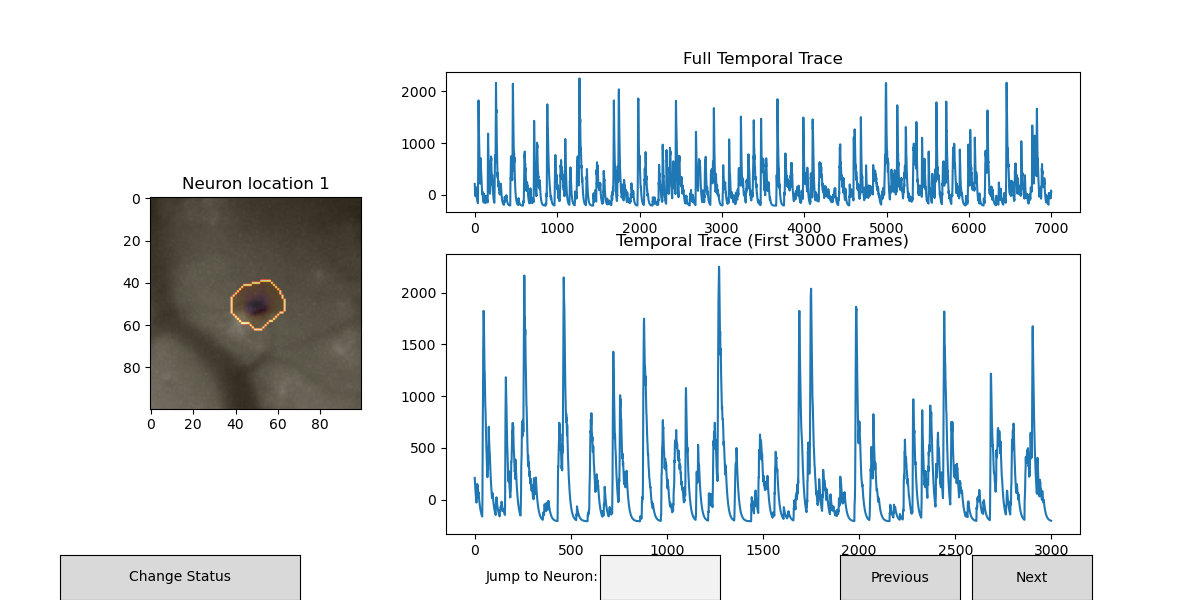

In [9]:
%matplotlib widget

# Original dimentions
d1 = 512
d2 = 512

# Initial component number
component_num = 0

A_array = A_array_filtered
C_array = C_array_filtered
status_array = np.zeros((A_array_filtered.shape[1]), dtype=int)

# Plot a certain neuron
def update_plot(component_num):
    spatial_component = A_array[:, component_num].reshape(d1, d2)
    temporal_component = C_array[component_num, :]
    centroid_x, centroid_y = calculate_centroid(A_array, component_num, d1, d2)

    # Define crop boundaries
    crop_size = 50
    x_min, x_max = round(max(0, centroid_x - crop_size)), round(min(d2, centroid_x + crop_size))
    y_min, y_max = round(max(0, centroid_y - crop_size)), round(min(d1, centroid_y + crop_size))
    print(x_min, x_max, y_min, y_max)
    crop_bounds = (y_min, y_max, x_min, x_max)
    # Crop the max_image and spatial_component
    cropped_image = max_image[y_min:y_max, x_min:x_max]
    cropped_spatial_component = spatial_component[y_min:y_max, x_min:x_max]
    
    axs[0].clear()
    axs[0].imshow(cropped_image, cmap='grey')
    axs[0].imshow(cropped_spatial_component, cmap='inferno_r', alpha=0.3)
    plot_boundaries(axs[0], spatial_component, crop_bounds)
    axs[0].set_title(f'Neuron location {component_num + 1}')
    
    # Plot temporal components
    temporal_component = C_array[component_num, :]
    axs[1].clear()
    axs[1].plot(temporal_component)
    axs[1].set_title('Full Temporal Trace')

    axs[2].clear()
    axs[2].plot(temporal_component[:3000])
    axs[2].set_title('Temporal Trace (First 3000 Frames)')
    
    plt.draw()

def next_neuron(event):
    global component_num
    component_num = (component_num + 1) % A_array.shape[1]
    update_plot(component_num)

def prev_neuron(event):
    global component_num
    component_num = (component_num - 1) % A_array.shape[1]
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    status_array[component_num] = 1 # if status_array[component_num] == 0 else 0
   # print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")

def on_key_g(event):
    global component_num, status_array
    if event.key == 'g':  # Change 'n' to your desired key
        status_array[component_num] = 1 # if status_array[component_num] == 0 else 0
        print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")
        update_plot(component_num)  


def plot_boundaries(ax, component, crop_bounds):
    # Crop the component
    y_min, y_max, x_min, x_max = crop_bounds
    cropped_component = component[y_min:y_max, x_min:x_max]
    # Convert to boolean if necessary
    cropped_component_bool = cropped_component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(cropped_component_bool)
    boundaries = cropped_component_bool & ~eroded

    # Overlay boundaries
    ax.imshow(boundaries, cmap='hot', alpha=0.5)


# Create plot with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 3])  # Adjust ratios as needed

ax1 = fig.add_subplot(gs[:, 0])  # First subplot for the neuron image
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for the entire trace
ax3 = fig.add_subplot(gs[1, 1])  # Third subplot for the zoomed trace

axs = [ax1, ax2, ax3]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)
fig.canvas.mpl_connect('key_press_event', on_key_g)
plt.show()

In [19]:
sum(status_array)


97

In [ ]:
bool(status_array)

In [11]:
# Convert status_array to a DataFrame
status_df = pd.DataFrame(status_array, columns=['Status'])
status_df.to_csv('goodneurons.csv', index=False)

In [16]:
polygon_points_df = pd.DataFrame(polygon_points, columns=['x', 'y'])

In [18]:
polygon_points_df.to_csv('good_poligon.csv', index=False)

In [48]:
neuron_tracs = C_array[status_array, :]
neuron_tracs.shape

(189, 6998)

In [50]:
stat = [n==1 for n in status_array]


In [51]:

A_array_filtered = A_array[:, stat]
neuron_traces = C_array[stat, :]

In [52]:
neuron_traces.shape

(97, 6998)

In [20]:
# Load event times
# Create and display a FileChooser widget
fc = FileChooser('D:/behav/')
fc.filter_pattern = '*.csv'
fc.use_dir_icons = True
display(fc)

FileChooser(path='D:\behav', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Chan…

In [44]:
file_path = fc.selected_path + '\\' + fc.selected_filename
data = pd.read_csv(file_path)
data_licks_L = pd.read_csv(file_path[0:-4] + '_t_licks_L.csv', header = None)
data_licks_R = pd.read_csv(file_path[0:-4] + '_t_licks_R.csv', header = None)

#data = data[data['laser_stim_ts']!=0]
#data['end_trial'] = data['laser_stim_ts'].shift(-1) 
#data['end_trial'].fillna( data['laser_stim_ts'][data.shape[0]-1] + 6000, inplace=True)


In [45]:
data.iloc[[31]]

left_correct  right_correct  left_tone_t  right_tone_t  side  missed  \
31           NaN            1.0      -148727        182279    -1       0   

    seq_laser  laser_ts  
31          0    183390

In [46]:
data.iloc[[32]]

left_correct  right_correct  left_tone_t  right_tone_t  side  missed  \
32           NaN            1.0      -148727        186842    -1       0   

    seq_laser  laser_ts  
32          1    187946

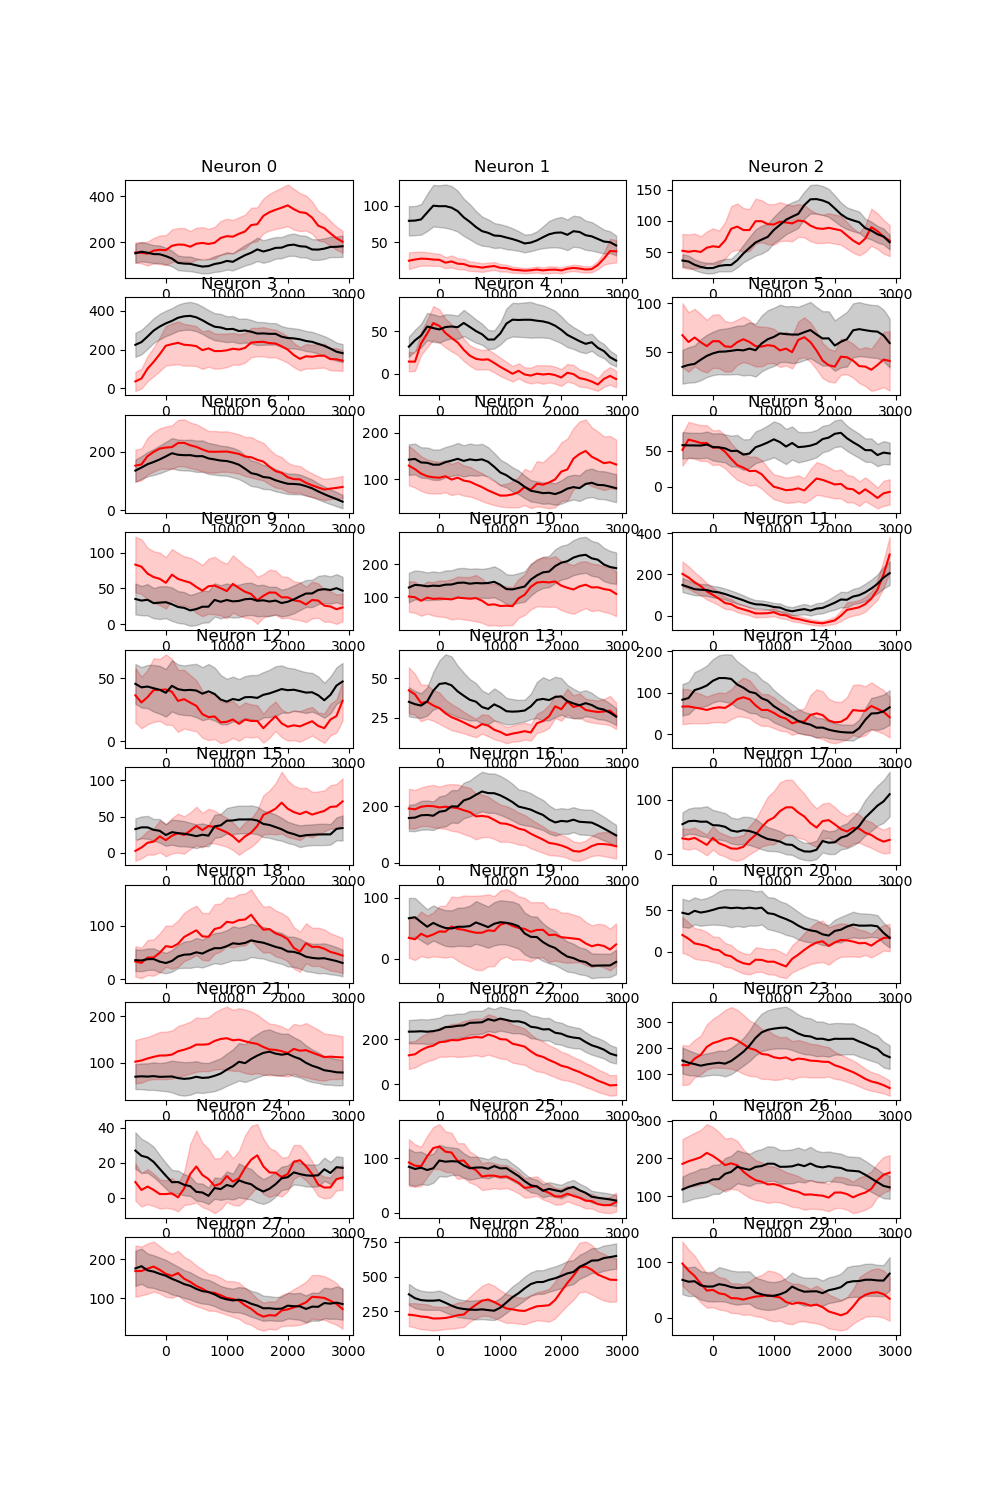

In [54]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(laser_type, n_id):
    times = data[data['seq_laser'] == laser_type]['laser_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    for i in [0,1,2]:
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)

        traces_0 = extract_data(0, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)

        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)

        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='k', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='k', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting
fig, axs = plt.subplots(10, 3, figsize=(10, 15))
neu_indx = np.arange(0,30,3)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n)


plt.show()






IndexError: index 10 is out of bounds for axis 0 with size 10

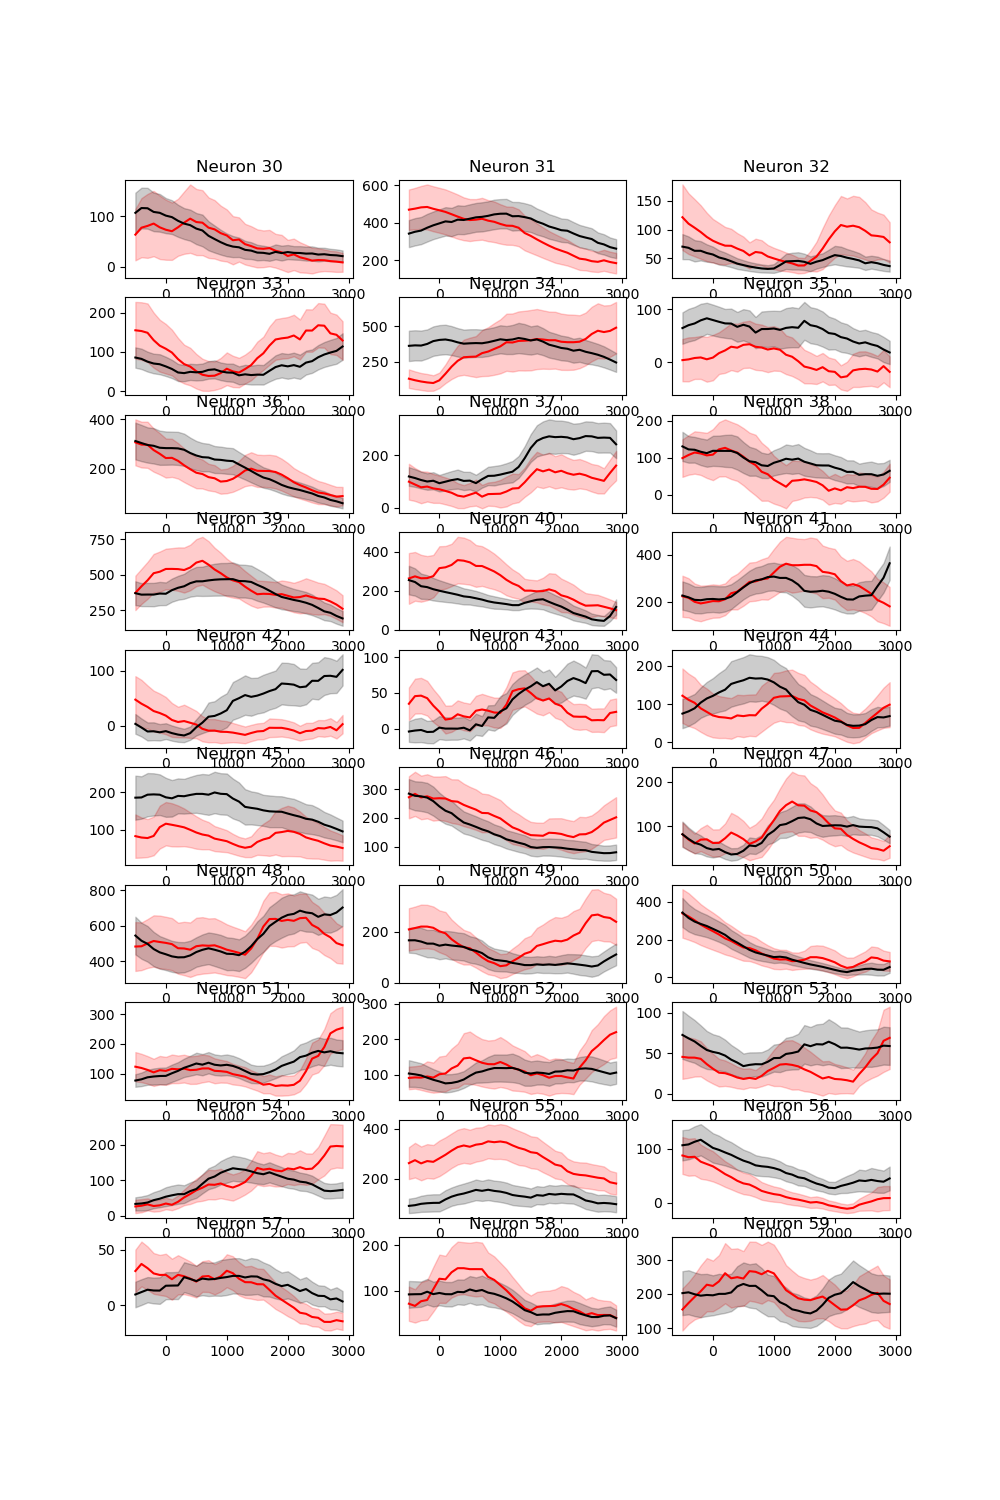

In [55]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(laser_type, n_id):
    times = data[data['seq_laser'] == laser_type]['laser_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    for i in [0,1,2]:
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)

        traces_0 = extract_data(0, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)

        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)

        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='k', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='k', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting
fig, axs = plt.subplots(10, 3, figsize=(10, 15))
neu_indx = np.arange(30,61,3)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n)


plt.show()






In [ ]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(laser_type, n_id):
    times = data[data['laser'] == laser_type]['laser_stim_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    for i in [0,1,2]:
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)
        traces_minus1 = extract_data(-1, neuron_id+i)
        traces_0 = extract_data(0, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)
        mean_trace_minus1 = np.mean(traces_minus1, axis=0)
        std_trace_minus1 = sem(traces_minus1, axis=0)
        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)
        # Laser = -1
        axs[ax_n,i].plot(time_points, mean_trace_minus1, color='b', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_minus1 - std_trace_minus1, mean_trace_minus1 + std_trace_minus1, color='b', alpha=0.2)
        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='k', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='k', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting
fig, axs = plt.subplots(10, 3, figsize=(10, 15))
neu_indx = np.arange(60,90,3)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n)

plt.show()

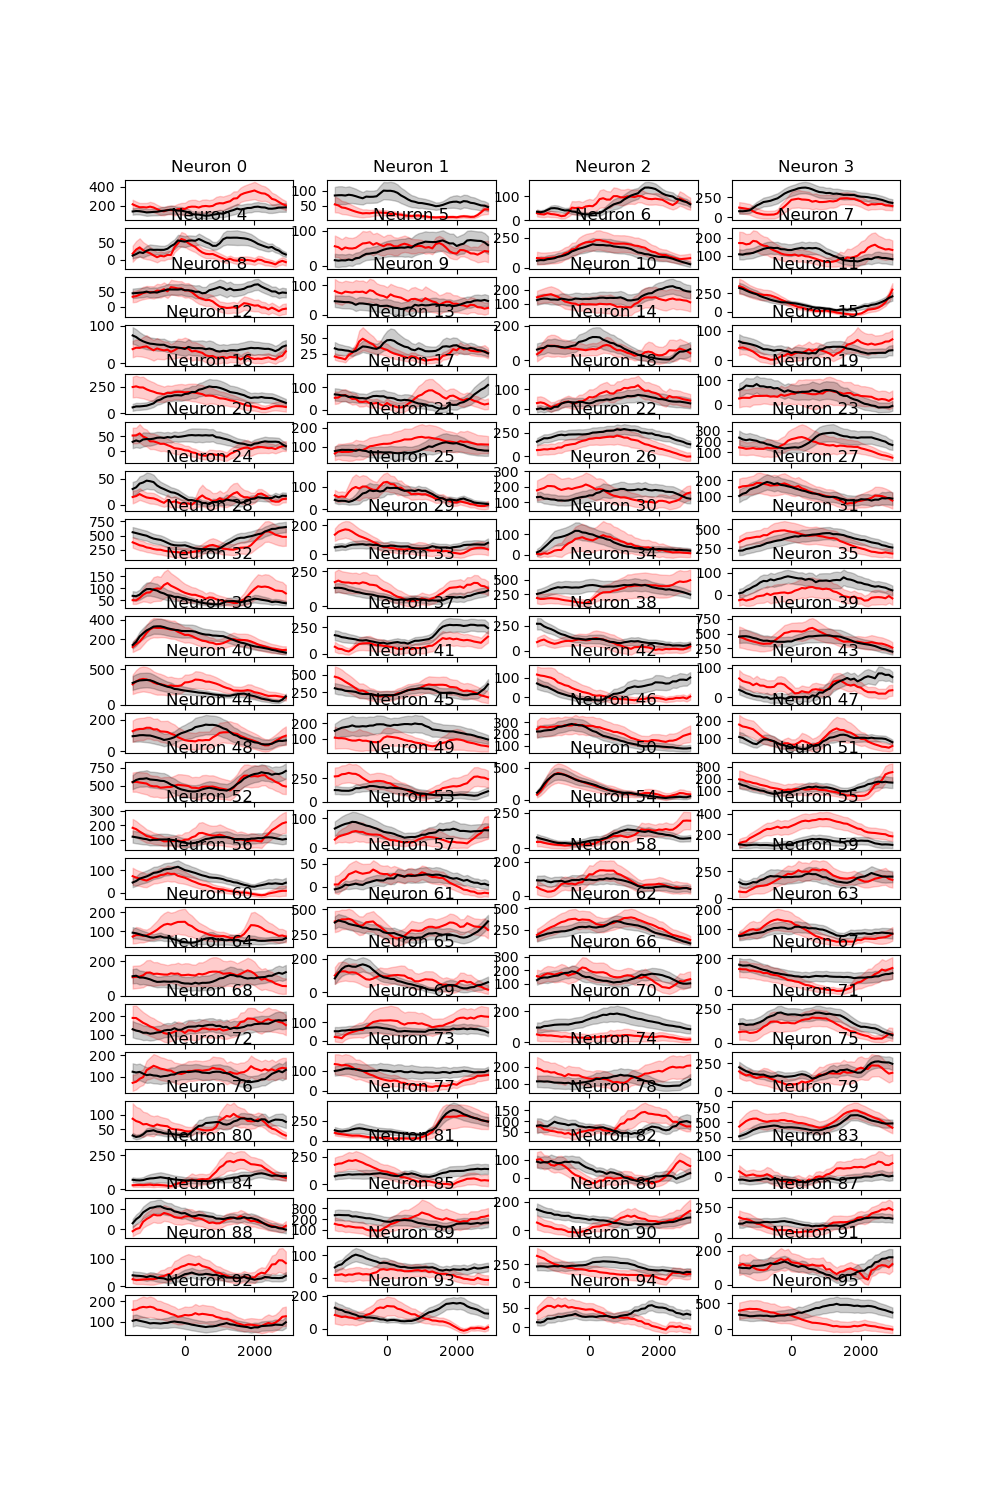

In [58]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 1500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(laser_type, n_id):
    times = data[data['seq_laser'] == laser_type]['laser_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n, cols):
    for i in np.arange(cols):
        if neuron_id+i>=neuron_traces.shape[0]:
            break
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)

        traces_0 = extract_data(0, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)

        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)

        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='k', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='k', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting
cols = 4
fig, axs = plt.subplots(24, cols, figsize=(10, 15))

neu_indx = np.arange(0,96,cols)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n, cols)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
neuron_id = 28  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(laser_type):
    times = data[data['laser'] == laser_type]['laser_stim_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[neuron_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)

# Extract data for each laser type
traces_1 = extract_data(1)
traces_minus1 = extract_data(-1)
traces_0 = extract_data(0)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Adjust these plots as needed
axs[0].plot(traces_1.T)  # Transpose for correct orientation
axs[0].set_title("Laser = 1")

axs[1].plot(traces_minus1.T)
axs[1].set_title("Laser = -1")

axs[2].plot(traces_0.T)
axs[2].set_title("Laser = 0")

plt.show()


In [ ]:
np.arange(0,16,2)

In [ ]:
post_event_points

In [ ]:
neuron_traces[2,1:3]

In [ ]:
neuron_traces.shape

In [ ]:
139/5